

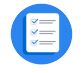

# Pace: Plan Stage

- Understand your data in the problem context
- Consider how your data will best address the business need
- Contextualize & understand the data and the problem


🗒
### Understand the business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They refer to you as a data analytics professional and ask you to provide data-driven suggestions based on your understanding of the data. They have the following question: what’s likely to make the employee leave the company?

Your goals in this project are to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company.

If you can predict employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

### Familiarize yourself with the HR dataset

The dataset that you'll be using in this lab contains 15,000 rows and 10 columns for the variables listed below. 

**Note:** For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

## Step 1. Imports

*   Import packages
*   Load dataset



### Import packages

In [ ]:
# Import packages
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

### Load dataset

In [ ]:
# Load dataset into a dataframe
df0 = pd.read_csv("/kaggle/input/hr-analytics-and-job-prediction/HR_comma_sep.csv")


# Display first few rows of the dataframe
df0.head()

## Step 2. Data Exploration (Initial EDA and data cleaning)

- Understand your variables
- Clean the dataset (missing data, redundant data, outliers)



### Gather basic information about the data

In [ ]:
# Gather basic information about the data
df0.info()

### Gather descriptive statistics about the data

In [ ]:
# Gather descriptive statistics about the data
df0.describe()

### Rename columns

Standardize the column names so that they are all in `snake_case`, correct any column names that are misspelled, and make column names more concise as needed.

In [ ]:
# Display all column names
df0.columns

In [ ]:
# Rename columns as needed
df0 = df0.rename(columns = {'Work_accident': 'work_accident',
                           'average_montly_hours': 'average_monthly_hours',
                           'Department': 'department',
                           'time_spend_company': 'tenure'})

# Display all column names after the update
df0.columns


### Check missing values

Check for any missing values in the data.

In [ ]:
# Check for missing values
df0.isnull().sum()

### Check duplicates

Check for any duplicate entries in the data.

In [ ]:
# Check for duplicates
df0.duplicated().sum()

In [ ]:
# Inspect some rows containing duplicates as needed
df0[df0.duplicated()]

In [ ]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df1 = df0.drop_duplicates(keep = 'first')

# Display first few rows of new dataframe as needed
df1.head()


### Check outliers

Check for outliers in the data.

In [ ]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
sns.boxplot(x = 'tenure', data = df1)
plt.title('Boxplot Outliers tenure')
plt.show()


In [ ]:
# Determine the number of rows containing outliers
percentile25 = df1['tenure'].quantile(0.25)
percentile75 = df1['tenure'].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print('lower limit:', lower_limit)
print('upperlimit:', upper_limit)

outliers = df1[(df1['tenure'] < lower_limit) | (df1['tenure'] > upper_limit)]
print('')
print('Total Outliers:', len(outliers))

Certain types of models are more sensitive to outliers than others. When getting to the stage of building your model, we will consider whether to remove outliers, based on the type of model you decide to use.

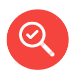
# pAce: Analyze Stage
- Perform EDA (analyze relationships between variables)



## Step 2. Data Exploration (Continue EDA)

### Data visualizations

Examining the variables that we are interested in, and create plots to visualize relationships between variables in the data.

We will start by ploting:
1. A Boxplot where we can see the distribution between the avg_monthly_hours vs the number of projects employees have, from employees who stayed and left.
2. A histogram that shows the distribution of number of project employees have, differenciated between the ones who stayed and the ones who left.

In [ ]:
# Create a plot
fig, ax = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(x = 'average_monthly_hours',
           y = 'number_project',
           data = df1,
            hue = 'left',
            orient = 'h',
           ax = ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly Hours vs Number of Projects', fontsize = '22')


sns.histplot(data = df1, 
             x = 'number_project',
             hue = 'left', 
             multiple = 'dodge',
             shrink = 2,
             ax = ax[1])
ax[1].set_title('Number of Projects Histogram', fontsize = '22')
ax[1].legend(labels = ['left', 'stayed'])

plt.show()

From the previous plots we can notice the following:
1. We can notice two groups. Those who work less than their peers with the same number of projectos (A), and the other one comprised of those who work much more (B).
We should consider the in group A they probably were fired and also it can contain people who had already resign, and therefore have less responsabilities. 
In group B, its reasonable that they have resign.
2. As the number of projects starts to increase above 3, you start to see more employees leaving. Getting to the point where all the employees who have 7 projects have left.
3. The ratio of left/stay is much lower when projects are between 3 and 4 per employee.
4. The avg monthly hours is above from common standarts. Assuming that the month have 21 working days, and that usually a person works 8 hours per day, its a total of 168 hours/month on average.

In [ ]:
# Create a plot
plt.figure(figsize = (16, 9))
sns.scatterplot(x = 'average_monthly_hours',
               y = 'satisfaction_level',
               data = df1,
               hue = 'left',
               alpha = 0.4)
plt.title('Satisfaction Level vs Avg. Monthly Hours', fontsize = '18')
plt.axvline(x = 168, color = 'Red', label = '168 hrs/month', ls = '--')
plt.legend(labels = ['168 hrs/month','left', 'stayed'])
plt.show()

We can notice the following form the previous plot:
1. There is a considerable group of people who left the company that worked ~240-350 hours/month that had very low satisfaction levels.
2. Another cluster of employees who left worked less than the standard avg. hours/month and their satisfaction level was low.
3. Finally theres a cluster that worked high avg monthly hours, had high satisfaction levels, and left the company.


Notice the strange shape of the distribution of the observation in the plot, its indicative of data manipulation or synthetic data for the following reasons:
1. Unnatural Clusters: data points form unnaturally perfect clusters, real world data tends to have more irregular and diverse clustering patterns.
2. Uniform Spacing: data points are uniformaley arrange in a highly regular pattern. In real world scenarios data points are often distributed unevenly.

Now we will plot satisfaction_levels and tenure:

In [ ]:
# Create a plot
fig, ax = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(x = 'satisfaction_level',
           y = 'tenure',
           data = df1,
           hue = 'left',
           orient = 'h',
           ax = ax[0])

ax[0].invert_yaxis()
ax[0].set_title('Boxplot Satisfaction Level vs Tenure', fontsize = '22')

sns.histplot(data = df1,
            x = 'tenure',
            hue = 'left',
            multiple = 'dodge',
            shrink = 5,
            ax = ax[1])

ax[1].set_title('Tenure Histogram', fontsize = '22')
ax[1].legend(labels = ['left', 'stayed'])

plt.show()


Our observations:
1. There are 2 categories of employees who left. The ones with medium length tenure and high satisfaction levels, and the ones with shorter tenure and low satisfaction levels. 
2. Theres a group of employees with 4 year tenure, who left and where really dissatisfied. It´s worth doing some research of what could be affecting this.
3. Satisfaction levels of low tenure and high tenure is very similar.
4. Most employees are between 2 and 4 tenure length. There are very few over 6 years tenure.
5. Once the employees have more than 3 years tenure the number of employees that leave decreases. Over 6 years tenure the are no employees who left the company.

We will calculte the mean and median satisfaction level of employees who stay and left the company.

In [ ]:
# Create a plot
df1.groupby(by = 'left')['satisfaction_level'].agg({'mean', 'median'})

The mean of the employees who left is ~23% lower than the ones who stayed. This distribution of of the ones who stayed seems to be somewhat skewed to the right, and the distribution from the ones who stayed somewhat skewed to the left.

We shall proceed eximining the salaray for different tenures.

In [ ]:
# Create a plot
fig, ax = plt.subplots(1, 2, figsize = (22, 8))

tenure_short = df1[df1['tenure'] < 7]
tenure_long = df1[df1['tenure'] >= 7]

sns.histplot(data = tenure_short,
           x = 'tenure',
           hue = 'salary', 
             hue_order = ['low', 'medium', 'high'],
           multiple = 'dodge',
           shrink = 6,
            ax = ax[0])

ax[0].set_title('Salary Histogram by Tenure: short-tenured employees', fontsize = '18')

sns.histplot(data = tenure_long,
            x = 'tenure',
            hue = 'salary',
             hue_order = ['low', 'medium', 'high'],
            multiple = 'dodge',
            shrink = 1,
            ax = ax[1])

ax[1].set_title('Salary Histogram by Tenure: long-tenured employees', fontsize = '18')


plt.show()

We notice the following:
1. For tenures below 7 years, the distribution of between salaries is pretty similar. 
2. For tenures over 7 years, we can notice that medium higher than high, and high is bigger than low. 
3. For long tenure emplyees, high salary doesn´t grow disproportionaly.

We will explore if there is any correlation between working long hours and evaluation scores.

In [ ]:
# Create a plot
plt.figure(figsize = (16, 9))
sns.scatterplot(data = df1,
               x = 'average_monthly_hours',
               y = 'last_evaluation',
               hue = 'left',
               alpha = 0.4)

plt.axvline(x = 168, color = 'Red', ls = '--')
plt.legend(labels = ['168 hrs/month' ,'left', 'stayed'])
plt.title('Monthly Hours by Last Evaluation Score', fontsize= '18')


Observations:
1. There are 2 clusters in the employees who left. The ones the worked long hours and had high last evaluation score, and the ones who worked less hours than the standard avg. monthly hours and had low score in their las evaluation. 
2. There seems to be some positive correlation between hours worked and evaluation scores.
3. There isn´t a high percentage of points in the higher eft quadrant, so working long hours doesn´t assure a high evaluation score.

We will explore whether the employees who worked long hours were promoted in the las 5 years.

In [ ]:
# Create a plot
plt.figure(figsize = (16, 3))

sns.scatterplot(data = df1,
               x = 'average_monthly_hours',
               y = 'promotion_last_5years',
               hue = 'left',
               alpha = 0.4)

plt.axvline(x = 168, color = 'Red',ls = '--')
plt.legend(labels = ['168 hrs/month', 'left', 'stayed'])
plt.title('Promotion in last 5 years by Avg. Monthly Hours', fontsize = '18')

plt.show()


Observations:
1. Very fue employees were promoted in the last few years.
2. Almost no employee who worked the longest hours were promoted in the last few years.
3. Almost everyone who left wasn´t promoted in the last 5 years.
4. Very few eomplyees who left were promoted in the las 5 years.

Explore the distribution of employees whi left across departments.

In [ ]:
# Create a plot
plt.figure(figsize = (11, 8))

sns.histplot(data = df1,
            x = 'department',
            hue = 'left',
            multiple = 'dodge',
            shrink = .5)

plt.xticks(rotation = 45)
plt.legend(labels = ['left', 'stayed'])
plt.title('Distribution left/stayed by Department', fontsize = '18')

plt.show()

There doesn´t seem to be significant changes in the distribution of left/stayed employees across departments.

Lastly, we are going to analize correlation between variables in the dataframe.

In [ ]:
plt.figure(figsize = (16, 9))

sns.heatmap(data = df0.corr(),
            vmin = -1,
            vmax = 1,
            annot = True,
           cmap = sns.color_palette('vlag', as_cmap = True)
           )

plt.title('Correlation between variables Heatmap', fontsize = '18', pad = 20)

plt.show()

Observations:
1. The correlation heatmap shows us that there is some positive correlation between average monthly hours, number of projects and evaluation score. 
2. There is a negative correlation between satisfaction level and the people who leave the company.

### Insights

1. There seems to that employees could be leaving because of long hours, many projects and low satisfaction levels. They are probably not comfortable working long hours and not receiving high evaluation scores or promotions during 5 years.
2. If they have more than 6 year tenure they tend not to leave the company.

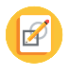
# paCe: Construct Stage
- Determine which models are most appropriate
- Construct the model
- Confirm model assumptions
- Evaluate model results to determine how well your model fits the data


## Step 3. Model Building, Step 4. Results and Evaluation
- Fit a model that predicts the outcome variable using two or more independent variables
- Check model assumptions
- Evaluate the model

### Identify the type of prediction task.

Our objective is to predict which employees will leave the company, determining which variables affect the most for an employee to leave the company.
Our dependent variable is categorical and binary (leave or not leave).

### Identify the types of models most appropriate for this task.

Since the dependent variable is categorical and binary, we should focus on Logistic Regression model or a Tree Based model (Machine Learning model).
So we will evaluate both to determine which one is more accurate to our objective and the context of our scenario.


We shall start with Logistic Regression and then proceed with Tree Based modeling.

### Modeling

#### Logistic Regression

We will star by hot-encoding de categorical variables.

In [ ]:
df_enc = pd.get_dummies(df1, prefix = ['salary', 'dept'], columns = ['salary', 'department'] ,drop_first = True)

df_enc.head()

We shall create a heatmap to analize correlation between variables we are interested.

In [ ]:
plt.figure(figsize = (8, 6))

interested_var = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']

sns.heatmap(df_enc[interested_var].corr(), vmin = -1, vmax = 1, annot = True, cmap = 'crest')

plt.title('Correlation Heatmap Interested Variables', fontsize = '18')

plt.show()

Logistic Regression models are very sensitive to outliers, so we will remove the ones from tenure that were identified in previous steps.

In [ ]:
df_logreg = df_enc[(df_enc['tenure'] > lower_limit) & (df_enc['tenure'] < upper_limit)]

df_logreg.head()

Determine dependant variable:

In [ ]:
y = df_logreg['left']
y.head()

Determine the dependants variables:

In [ ]:
X = df_logreg.drop('left', axis = 1)
X.head()

Split our data in train and test groups:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Construct the model and fit the train data:

In [ ]:
log_clf = LogisticRegression(random_state = 42, max_iter = 500)

log_clf.fit(X_train, y_train)

Now we use the model to make predictions on the test data:

In [ ]:
y_pred = log_clf.predict(X_test)

We will display the predicted results vs the y_test on a Confusion Matrix, to visualize the distribution of the results of the model:

In [ ]:
log_cm = confusion_matrix(y_test, y_pred, labels = log_clf.classes_)

log_disp = ConfusionMatrixDisplay(confusion_matrix = log_cm, display_labels = log_clf.classes_)

log_disp.plot()

plt.show()

Quadrants display:
1. Upper left: number of true negatives.
2. Bottom right: number of true positives.
3. Upper right: number of false positives.
4. Bottom left: number of false negatives.


Meaning if each quadrant:
1. True negatives: number of employees the model predicted that would stay, and actually stayed.
2. True positives: number of employees the model predicted that would leave, and actually left.
3. False positives: number of emplyees the model predicted that would leave, and actually stayed.
4. False negatives: number of employees the model predicted that would stay, and actually left.

A perfect model would yield true positives and true negatives, and no false positives and false negatives.



Now we can evaluate the model performance by accuracy, precision, recall and f1.

First we will check the balance of the data. Since this is a binary classification task, the class balance informs the way you interpret the accuracy metrics.

In [ ]:
df_logreg['left'].value_counts(normalize = True)

The data on the dependant variable is inbalance, ~83% of the observation stayed and ~17% left.
The data is not perfectly balanced (50-50), but is not extremely inbalanced that we would need to resample or modifying the data. We can continue to evaluate the model.

In [ ]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names = target_names))

### Tree-based Model

In this approach we will implement Decision Tree and Random Forest.

Import necessary libraries, packages and modules.

In [ ]:
# For data modeling.
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions.
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

# For saving models
import pickle

We will encode the categorical variables:

In [ ]:
df2 = pd.get_dummies(df1)
df2.head()

Define the outcome variable:

In [ ]:
y = df2['left']
y.head()

Define features:

In [ ]:
X = df2.drop('left', axis = 1)
X.head()

Split data into train, validate and test sets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.25, stratify = y_train, random_state = 0)

#### Decision Tree - Round 1

Construct a decision tree model and set up cross-validation grid-search, to find best parameters.

In [ ]:
# Instantiate the model
tree = DecisionTreeClassifier(random_state = 0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [4, 6, 8, None ],
            'min_samples_leaf': [2, 5, 1],
            'min_samples_split': [2, 4, 6],
            }
# Assign a dictionary of scoring metrics to evaluate
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring = scoring, cv = 4, refit = 'roc_auc')

Fit the model to the training data.

In [ ]:
%%time
tree1.fit(X_tr, y_tr)

Identify the best values for the decision tree hyperparameters

In [ ]:
tree1.best_params_

Obtain the best AUC score achieved by the decision tree model on the training set

In [ ]:
tree1.best_score_

The AUC score is really good, so the model is really good at predicting which employees will leave.

We will oberve all the scores that the model achieve.

In [ ]:
def make_results(model_name: str, model_object, metric: str):
    """
    Arguments:
        model_name(string): what you want the model to be called in the output table.
        model_object: a fit GridSearchCV object.
        metric(string): precision, recall, f1, accuracy or auc.
        
    Returns a pandas dataframe with the precision, recall, accuracy, f1, and auc scores
    for the model with the best mean metric score across all validation folds.
    """
    
    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                  'precision': 'mean_test_precision',
                  'recall': 'mean_test_recall',
                  'f1': 'mean_test_f1',
                  'accuracy': 'mean_test_accuracy'
                  }
    
    # Get all the results from the CV and put them in a datafram
    cv_results = pd.DataFrame(model_object.cv_results_)
    
    # Isolate the row of the dataframe with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]
    
    # Extract accuracy, precision, recall, f1 and auc from that row
    accuracy = best_estimator_results.mean_test_accuracy
    precision = best_estimator_results.mean_test_precision
    recall = best_estimator_results.mean_test_recall
    f1 = best_estimator_results.mean_test_f1
    auc = best_estimator_results.mean_test_roc_auc
    
    # Create table of results
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                         'AUC': auc,
                         'Precision': precision,
                         'Recall': recall,
                         'F1': f1,
                         'Accuracy': accuracy
                         },
                            ignore_index = True
                        )
    return table
    

Lets obtain the scores from the Grid Search

In [ ]:
tree1_cv_results = make_results('Decision Tree CV', tree1, 'auc')
tree1_cv_results

All the performance metric are high, this indicates that the model is strong.

We need to remember that Decision-Trees are vulnerable to overfitting. 

Random Forests avoid overfitting by incorporating multiple trees to make predictions. We should evaluate that model.

#### Random Forest - Round 1

Lets construct a Random Forest model and set up Cross-Validation GridSearch to search for the best model parameters.

In [ ]:
# Instantiate model
rf = RandomForestClassifier(random_state = 0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3, 5, None],
             'max_features': [1.0],
            'max_samples': [0.7, 1.0],
            'min_samples_leaf': [1, 2, 3],
            'min_samples_split': [2, 3, 4],
            'n_estimators': [300, 500]
            }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring = scoring, cv = 4, refit = 'roc_auc')

We fit the model to the training data.

In [ ]:
%%time
rf1.fit(X_tr, y_tr) # Wall time: ~9 min.

We specify a path to save our model.

In [ ]:
#path = '/your/file/path/'

In [ ]:
#def write_pickle(path, model_object, save_as: str):
#    """
#    In:
#        path: path of the folder where you want to save the pickle
#        model_object: a model you want to pickle
#        save_as: filename for how you want to save the model
        
#    Out: a call to pickle the model in the folder indicated 
#    """
    
#    with open(path + save_as + '.pickle', 'wb') as to_write:
#        pickle.dump(model_object, to_write)

In [ ]:
#def read_pickle(path, saved_model_name: str):
#    """
#    In:
#        path:path to the folder where you want to read from
#        saved_model_name: filename of pickle model you want to read
        
#    Out:
#        model: the pickled model
#    """
    
#    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
#        model = pickle.load(to_read)
        
#    return model

Use the functions defined previously to save the model in a pickle fil and then read it in.

In [ ]:
# write_pickle(path, rf1, 'hr_rf1')

In [ ]:
#rf1 = read_pickle(path, 'hr_rf1')

Lets obtain the best AUC score achieved by the Random Forest model on the training set.

In [ ]:
rf1.best_score_

Lets obtain the optimal hyperparameters values

In [ ]:
rf1.best_params_

Now we collect the evaluation scores on the training data sets from Decision Tree and Random Forest

In [ ]:
rf1_cv_results = make_results('Random Forest CV', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

All Random Forest scores are better than the Decision Tree model, except for Recall, which is almost the same. This indicates that the Random Forest Model outperformed the Decision Tree Model.

We will continue to evaluate the models on the validation set.

Lets define a function that obtains the all the scores of a models predictions.

In [ ]:
def get_scores(model_name: str, model, X_test_data, y_test_data):
    """
    Generate a table of test scores.
    
    In: 
        model_name (string): how you want the model to be named in the output table
        model: a fitGridSearchCV object
        X_test_data: numpy array of X_test data
        y_test_data: numpy array of y_test data
    
    Out: a pandas dataframe with accuracy, precision, recall, f1, and AUC scores for your model
    """
    
    preds = model.best_estimator_.predict(X_test_data)
    
    auc = round(roc_auc_score(y_test_data, preds), 3)
    accuracy = round(accuracy_score(y_test_data, preds), 3)
    precision = round(precision_score(y_test_data, preds), 3)
    recall = round(recall_score(y_test_data, preds), 3)
    f1 = round(f1_score(y_test_data, preds), 3)
    
    table = pd.DataFrame({'model': [model_name],
                         'AUC': [auc],
                         'precision': [precision],
                         'recall': [recall],
                         'f1': [f1],
                         'accuracy': [accuracy]
                         }
                        )
    
    return table

Lets get the the results using the table recently define

In [ ]:
# Get the results on the validation set for both models
tree1_val_results = get_scores('decision tree1 val', tree1, X_val, y_val)
rf1_val_results = get_scores('random forest1 val', rf1, X_val, y_val)

# Concatenate validation scores into table
all_val_results1 = [tree1_val_results, rf1_val_results]
all_val_results1 = pd.concat(all_val_results1).sort_values(by = 'AUC', ascending = False)
all_val_results1

The Random Forest has better metrics than the Decision Tree model on the validation data, except for a small difference on recall score.

We will use the the Random Forest model, that outperformend the Decision Tree model, to predict on the test set.

In [ ]:
rf1_test_scores = get_scores('random forest 1 test', rf1, X_test, y_test)
rf1_test_scores

Almost all test scores are even better on the test sets. This model seems to be strong. We only used the test set for this model, so we can be confident that the performance data is representative of how it will perform in new data.

#### Feature Engeneering

The evaluations scores are really high, that makes as a little bit sckeptical. There could be some data leakage.

It's likely that the company won't have satisfaction levels reported for all of its employees. Also, is possible that the average_monthly_hours column is a source of some data leakage. If employees have already decided upon quitting, or have already identified by management as people to be fired, they may be working fewer hours. 

The first round of decision tree and random forest models included all variables as features. Now we will incorporate feature engineering to build improved models.

We will drop satisfaction_level and create a new feature that roughly captures whether an employee is overworked. We will call feature overworked, it is a binary variable.

In [ ]:
df3 = df1.drop('satisfaction_level', axis = 1)
df3.head()

In [ ]:
df3['overworked'] = df3['average_monthly_hours']

print('Min Avg. Hours:', df3['overworked'].min())
print('Max Avg. Hours:', df3['overworked'].max())

International standards indicates that the average monthly hours should be 168.

We will define being overworked when hours are over 175.

In [ ]:
# Transoform overworked to a boolean variable (True, False)
df3['overworked'] = df3['overworked'] > 175

# Transform True and False to 1 and 0
df3['overworked'] = df3['overworked'].astype(int)
df3.head()

Now we can drop average_monthly_hours

In [ ]:
df3 = df3.drop('average_monthly_hours', axis = 1)
df3.head()

Lets hot-encode the categorical variables

In [ ]:
df4 = pd.get_dummies(df3, drop_first = False)
df4.head()

Lets define the outcome variable.

In [ ]:
y = df4['left']
y.head()

Define the features.

In [ ]:
X = df4.drop('left', axis = 1)
X.head()

Split data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.25, stratify = y_train, random_state = 0)

#### Descision Tree - Round 2

In [ ]:
# Instantiate the model
tree = DecisionTreeClassifier(random_state = 0)

# Define dictionary of hyperparameters
cv_params = {'max_depth': [4, 6, 8, None],
            'min_samples_leaf': [2, 5, 1],
            'min_samples_split': [2, 4, 6]
            }

# Define scoring dictionary
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearchCV
tree2 = GridSearchCV(tree, cv_params, scoring = scoring, cv = 4, refit = 'roc_auc')

In [ ]:
%%time
tree2.fit(X_tr, y_tr)

In [ ]:
tree2.best_params_

In [ ]:
tree2.best_score_

This model still performs very well, with the modifications we have made.

Let's check other scores.

In [ ]:
tree2_cv_results = make_results('Decision Tree2 CV', tree2, 'auc')
tree2_cv_results

Some of the scores are lower. Thats to be expected for the changes we made (fewer features). The model still performs very well.

#### Random Forest - Round 2

In [ ]:
# Instantiate the model
rf = RandomForestClassifier(random_state = 0)

# Define hyperparameters dictionary
cv_params = {'max_depth': [3, 5, None],
            'max_features': [1.0],
            'max_samples': [0.7, 1.0],
            'min_samples_leaf': [1, 2, 3],
            'min_samples_split': [2, 3, 4],
            'n_estimators': [300, 500]
            }

# Define scoring dictionary
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring = scoring, cv = 4, refit = 'roc_auc')

In [ ]:
%%time
rf2.fit(X_tr, y_tr) # Wall time: ~6 min.

In [ ]:
# write_pickle(path, rf2, 'hr_rf2')

In [ ]:
# rf2 = read_pickle(path, 'hr_rf2')

In [ ]:
rf2.best_params_

In [ ]:
rf2.best_score_

Lets see the other scores.

In [ ]:
rf2_cv_results = make_results('Random Forest2 CV', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

The scores on the Random Forest are a little bit lower, but still performs really good. Random Forest still outperformed Decision Tree model.

Now we test the models on the validation sets.

In [ ]:
# Collect validation scores
tree2_val_results = get_scores('Decision Tree2 Val', tree2, X_val, y_val)
rf2_val_results = get_scores('Random Forest2 Val', rf2, X_val, y_val)

# Concatenate validation scores into table
all_val_results2 = [tree2_val_results, rf2_val_results]
all_val_results2 = pd.concat(all_val_results2).sort_values(by = 'AUC', ascending = False)
all_val_results2

Seems that Random Forest perform slightly better across most evaluation metrics.

Lets use the Random Forest to predict on the test set.

In [ ]:
# Get predictions on test data
rf2_test_scores = get_scores('Random Forest2 test', rf2, X_test, y_test)
rf2_test_scores

Now lets use Random Forest model to predict on the test set.

In [ ]:
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels = rf2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf2.classes_)

disp.plot()

plt.show()


Lets continue to explore the splits on the Decision Tree and the most important features in the Random Forest.

In [ ]:
# Plot the tree
plt.figure(figsize = (85, 20))
plot_tree(tree2.best_estimator_, max_depth = 6, fontsize = 14, feature_names = X.columns,
         class_names = {0: 'stayed', 1: 'left'}, filled = True)

plt.show()

#### Decision Tree feature importance

We can also get the feature importance on a Decision Tree model.

In [ ]:
# tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns = X.columns)
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns = ['gini_importance'], 
                                 index = X.columns)
tree2_importances = tree2_importances.sort_values(by = 'gini_importance', ascending = False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] > 0]
tree2_importances

Lets visualize them in a bar plot.

In [ ]:
sns.barplot(data = tree2_importances,
           x = 'gini_importance',
           y = tree2_importances.index)

plt.title('Decision Tree: Feature Importances', fontsize = '14')
plt.ylabel('Features')
plt.xlabel('Importance')

plt.show()

The most important features, in this model, for predicting which employees will leave are: 
1. Number of projects.
2. Last evaluation.
3. Tenure.
4. Overworked

#### Random Forest featur importances

In [ ]:
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of the top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of the top 10 features
feat = X.columns[ind]

# Filter 'feat_impt' to consist of the top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({'Feature': feat, 'Importance': feat_impt})
y_sort_df = y_df.sort_values('Importance')

fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind = 'barh', ax = ax1, x = 'Feature', y = 'Importance')

ax1.set_title('Random Forest: Feature Importances', fontsize = '14')
ax1.set_ylabel('Feature')
ax1.set_xlabel('Importance')

plt.show()

The previous visualization shows us the most important features, to this model, for prediciting which empoyees could leave the company are:
1. Last evaluation.
2. Number of projects.
3. Tenure.
4. Overworked.

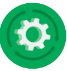
# pacE: Execute Stage
- Interpret model performance and results
- Share actionable steps with stakeholders



## Evaluation metrics definitions

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.






## Step 4. Results and Evaluation
- Interpret model
- Evaluate model performance using metrics
- Prepare results, visualizations, and actionable steps to share with stakeholders




### Summary of model results

#### Logistic Regression Model

The logistic regression model achieved the following wighted average scores on the test set:
- Precision: 79%
- Recall: 82%
- F1-score: 80% 
- Accuracy: 82%

#### Tree-based Machine Learning Model

After conducting feature engineering, the decision tree model achieved the following results on the test set: 
- AUC: 94.2% 
- Precision: 88.3%
- Recall: 90.7%
- F1-score: 89.5%
- Accuracy: 96.5%

#### Random Forest Machine Learning Model

- AUC: 93.3% 
- Precision: 90.5%
- Recall: 88.4%
- F1-score: 89.5%
- Accuracy: 96.5%

##### The random forest model slightly outperformed the decision tree model.

On the test set the Random Forest model performed as follows:

- AUC: 93.5% 
- Precision: 89.8%
- Recall: 88.9%
- F1-score: 89.4%
- Accuracy: 96.5%

### Conclusion, Recommendations, Next Steps

- Control and limit the number of projects that an employee can work on simultaneously.
- Conduct further investigations about why 4 year tenure employees are so dissatisfied.
- Reward employees that work long hours and give them some kind of recognition (promotion, salary, bonuses, company awards).
- Create  culture, incentives and polocies of healthier work/life balance.
- High evaluation scores shouldn´t be reserved only for eployees who work long hours.

#### Next Steps
- Address and conduct further verifications for data leakage.
- Consider how predictions change when last_evaluation is removed from the data. It´s possible that evaluations aren´t performed frequently.It colud be useful to predict retention whithout this feature.
- There could further analysis building K-means model and analyzing the clusters, this may give valuable insights.